In [1]:
library(gggenomes)
library(tibble)
library(tidyverse)
library(heatmaply)
library(jcolors)
library(grid) # for unit()
library(RColorBrewer)
library(reshape)

Loading required package: ggplot2


Attaching package: ‘gggenomes’


The following object is masked from ‘package:graphics’:

    layout


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::pick()   masks gggenomes::pick()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: plotly


Attaching package: ‘plotly’


The following object is masked from ‘package:gggenomes’:

    layout


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

   

In [2]:
locus_name<-c("HD", "PR")
full_name<-c("Pca203", "Pt76", "Pgt210", "Pst134E")
folder<-"/mnt/data/dayhoff/home/scratch/u6575017/"
#Import mating type gene list
MAT_list<-read.table(paste0(folder,"4fungi_gggenome/MAT.list"), header=FALSE, sep=" ")
colnames(MAT_list)<-c("gene_id", "MAT")
for (i in full_name){
    gff<-read.table(paste0(folder,"4fungi_gggenome/",i,".gene.gff"), header=FALSE, sep="\t")%>%select(V1,V3,V4,V5,V7,V9)%>%filter(V3=="gene")
    colnames(gff)<-c("seq_id", "type", "start", "end", "strand", "feat_id")
    assign(paste0(i,"_gff"), gff)
}

In [3]:
get_flanking<-function(gff, gene, flank){
    #if featid dont have ; at the end, add it
    gene <- ifelse(substr(gene, nchar(gene), nchar(gene)) != ";", paste0(gene, ";"), gene)
    gff<-gff%>%mutate(feat_id=paste0(feat_id, ";"))%>%arrange(seq_id, start)
    indices <- grep(paste(gene, collapse = "|"), gff$feat_id, value = FALSE)
    for (i in indices){
        indices_before <-i-flank
        indices_after <-i+flank
        indices_range <-c(indices_before:indices_after)
        #append the indices_range to a new vector
        if (i==indices[1]){
            indices_all <-indices_range
        }else{
            indices_all <-c(indices_all, indices_range)
        }
    }
    indices_all<-unique(indices_all)
    result <- gff[indices_all, ]%>%mutate(feat_id=gsub(";","",feat_id))%>%mutate(type="CDS")%>%mutate(feat_id=gsub("Name=.*","",feat_id))
    return(result)
}

In [4]:
HD_list <- MAT_list %>% filter(grepl("bW-HD1|bE-HD2", MAT))
STE3.2_list<-MAT_list%>%filter(grepl("STE3.2-2", MAT))
STE3.3_list<-MAT_list%>%filter(grepl("STE3.2-3", MAT))
STE3.1_list<-MAT_list%>%filter(grepl("STE3.2-1", MAT))

In [5]:
Annotation_gff<-rbind(Pca203_gff, Pt76_gff, Pgt210_gff, Pst134E_gff)
Annotation_gff<-merge(Annotation_gff, MAT_list, by.x="feat_id", by.y="gene_id", all.x=TRUE)

In [6]:
blast <- read_feats(paste0(folder,"4fungi_gggenome/Rust_cds.o6"))
colnames(blast) <- c("file_name", "feat_id", "feat_id2", "pident", "length", "mismatch", "gapopen", "start", "end", "start2", "end2", "evalue", "bitscore")
#colnames(blast)<-c("query", "subject", "identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore")
blast<-blast%>%filter(pident>=70)%>%mutate(feat_id=gsub("-T.*","",feat_id))%>%mutate(feat_id2=gsub("-T.*","",feat_id2))


Reading 'blast' with `read_blast()`:
* file_id: Rust_cds [/mnt/data/dayhoff/home/scratch/u6575017/4fungi_gggenome/Rust_cds.o6]


In [7]:
for (i in full_name){
    RM<-read.table(paste0(folder,"4fungi_gggenome/",i,"_repet_o_renamed.gff3"), header=FALSE, sep="\t", row.names=NULL, comment.char="#")
    RM<-RM%>%arrange(V1,V4,V5)%>%filter(V3=="match")
    #drop fuplicate base on V4 and V5
    RM<-RM%>%distinct(V1,V4, V5, .keep_all = TRUE)%>%mutate(V9 =gsub("ID=.*.Target=","",V9))%>%mutate(V9 =gsub(" .*.Identity=", " ",V9))%>%
mutate(V9 =gsub(";.*", " ",V9))%>%mutate(V9 =gsub(" ", "\t",V9))%>%separate(V9, c("feat_id", "IDY"), sep="\t")
    colnames(RM)<-c("seq_id", "source", "type", "start", "end", "phase", "strand", "tmp", "feat_id", "IDY")
    RM<-RM%>%mutate(file_id =i, parent_ids=feat_id, introns=NA)%>%select(file_id, seq_id, start, end, IDY, strand, type, feat_id, introns, parent_ids, source)%>%
        filter(type == "match")
    assign(paste0(i,"_RM"), RM)
    }

Warning message:
“Expected 2 pieces. Additional pieces discarded in 201203 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 280485 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 136151 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 133396 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [9]:
coords_header<-c("start", "end", "start2", "end2", "LEN1", "LEN2", "IDY", "length", "length2", "COV_R", "COV_Q", "seq_id", "seq_id2")
read_coords<-function(file){
    coords<-read.table(file, skip=4, header=FALSE, sep="\t", row.names=NULL)
    colnames(coords)<-coords_header
    coords<-coords%>%filter(LEN1>=1000)%>%filter(LEN2>=1000)%>%filter(IDY>=90)
    coords<-coords%>%mutate(file_id="Pt")%>%mutate(strand=ifelse(start2<end2, "+", "-"))%>%select(file_id, seq_id, length, start, end, strand, seq_id2, length2, start2, end2)
    return(coords)
}

In [10]:
coords<-read_coords(paste0(folder,"4fungi_gggenome/MAT_chr.coords"))

In [11]:
RM_all<-rbind(Pca203_RM, Pt76_RM, Pgt210_RM, Pst134E_RM)

In [12]:
#This function is to reclassify the REPET classification if hits have high identity to the TE library
reclass_REPET<-function(files){
class_if<-read.csv(files, header=TRUE)
sub_class_if_determined<-class_if%>%filter(confused=="False")%>%select(seq_name, class_classif, order_classif, Wcode)
sub_class_if_undetermined<-class_if%>%filter(confused=="True")
reclass<-sub_class_if_undetermined %>%
    select(seq_name, coding, other) %>% 
    mutate(coding = str_replace(coding, "coding=\\(", ""))%>%mutate(coding = gsub("profiles.*\\)", "", coding))%>%
    mutate(coding = str_replace(coding, ":", ""))%>%
    mutate(coding = str_replace(coding, "\\)", ""))%>%
    mutate(other=gsub("other=\\(", "",other))%>%
    mutate(other=gsub("\\)", "",other))%>%mutate(other=gsub("; TElength.*", "", other))%>%
    mutate(other=gsub("TE_BLRtx:|TE_BLRx:|profiles.*|TermRepeats.*", "", other))
for (i in 1:nrow(reclass)){
tmp_records<-reclass[i,]%>%as.data.frame()
    seq_id<-tmp_records$seq_name
    if (grepl("Class", tmp_records$coding) == TRUE){
    records<-strsplit(tmp_records$coding, "; |, ")[[1]]
    records<-data.frame(seq_id=seq_id, record=records)%>%separate(record, into=c("annotation", "identity"), sep=":(?=[^:]*$)" )
    }else{
    records<-NULL
    }
    if (grepl("Class", tmp_records$other) == TRUE){
    extra<-tmp_records$other
    extra_records<-strsplit(extra, "; |, ")[[1]]
    extra_records<-data.frame(seq_id=seq_id, record=extra_records)%>%separate(record, into=c("annotation", "identity"), sep=":(?=[^:]*$)" )    
    records<-rbind(records, extra_records)%>%
    mutate(max_identity= ifelse(max(as.numeric(gsub("%", "", identity))) >= 70 & 
    as.numeric(gsub("%", "", identity)) == max(as.numeric(gsub("%", "", identity))), max(as.numeric(gsub("%", "", identity))), NA))%>%drop_na(max_identity)
    }else if (grepl("Class", tmp_records$coding) == TRUE){
    records<-records%>%group_by(seq_id)%>%
    mutate(max_identity= ifelse(max(as.numeric(gsub("%", "", identity))) >= 70 & 
    as.numeric(gsub("%", "", identity)) == max(as.numeric(gsub("%", "", identity))), max(as.numeric(gsub("%", "", identity))), NA))%>%drop_na(max_identity)
    }else{
    records<-NULL
    }
    if (!is.null(records) && nrow(records) > 0){
       records<-records%>%mutate(annotation=gsub(".*Class", "Class", annotation))
    }else{
     records<-data.frame(seq_id=seq_id, annotation="Undetermined", identity=NA, max_identity=NA)
    }
    if(i == 1){
        records_new<-records
    }else{
        records_new<-rbind(records_new, records)
    }
}
records_new<-records_new %>%
  separate(annotation, into = c("Class", "Order","WCode"), sep = ":", fill = "right")%>%
  mutate(Order=ifelse(Order=="?", paste0("Undetermined ", Class), Order))%>% 
  select("seq_id","Class","Order","WCode")
colnames(records_new)<-c("seq_name","class_classif","order_classif","Wcode")
sub_class_if_undetermined<-records_new
class_RM<-rbind(sub_class_if_determined, sub_class_if_undetermined)%>%mutate(order_classif=ifelse(order_classif=="Unclassified" & 
    class_classif!="Unclassified", paste0("Undetermined ", class_classif ), order_classif))%>%
    mutate(order_classif = ifelse(is.na(order_classif)& !is.na(class_classif), paste0("Undetermined ", class_classif ), order_classif))%>%
    mutate(order_classif=ifelse(is.na(class_classif) & !is.na(Wcode), Wcode, order_classif))
colnames(class_RM)<-c("parent_ids", "class", "order", "Wcode")
class_RM<-class_RM%>%mutate(order = ifelse(order == "Unclassified" | order == "NA", "Undetermined", order))%>%
    mutate(order = gsub("Class", "", order))%>%mutate(order = gsub("Undetermined Undetermined", "Undetermined", order))
#reorder class_RM
class_RM <- class_RM[match(class_if$seq_name, class_RM$parent_ids), ]
file_name <-files%>%gsub("_sim_consensus_classif.csv", "_reclass.csv", .)
write.csv(class_RM, file = file_name, row.names = FALSE)
return(class_RM)
}
Pt76.RM_class<-reclass_REPET(paste0(folder,"4fungi_gggenome/Pt76_sim_consensus_classif.csv"))
Pgt210.RM_class<-reclass_REPET(paste0(folder,"4fungi_gggenome/Pgt_210_hapA_sim_consensus_classif.csv"))
Pst134E.RM_class<-reclass_REPET(paste0(folder,"4fungi_gggenome/Pst134E_sim_consensus_classif.csv"))
Pca203.RM_class<-reclass_REPET(paste0(folder,"4fungi_gggenome/Pca_12NC29_ph_sim_consensus_classif.csv"))
class_RM<-rbind(Pt76.RM_class, Pgt210.RM_class, Pst134E.RM_class, Pca203.RM_class)


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [2, 3].”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_identity = ifelse(...)`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [2, 3].”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_identity = ifelse(...)`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1 rows [3].”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_identity = ifelse(...)`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to se

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 640 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


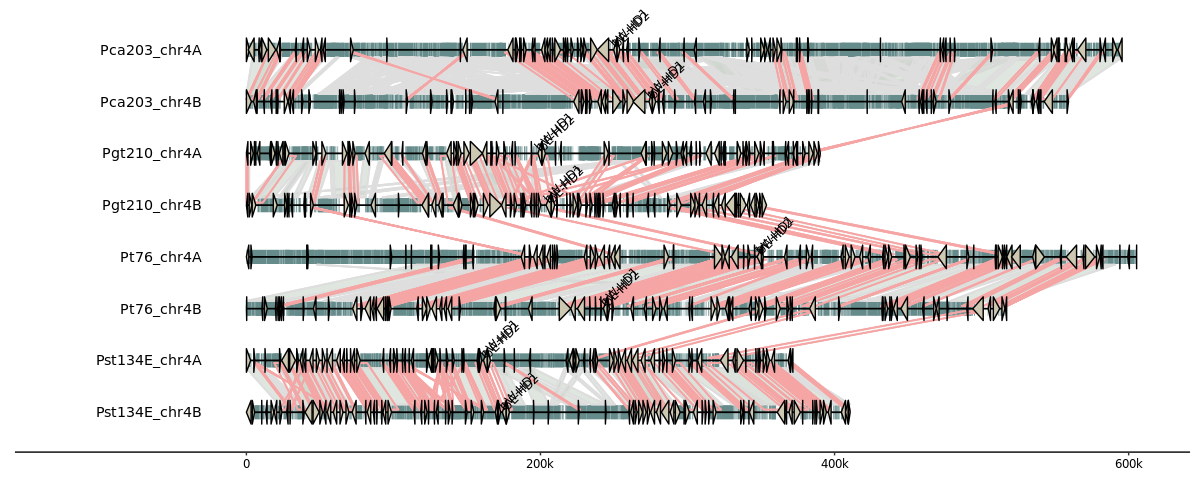

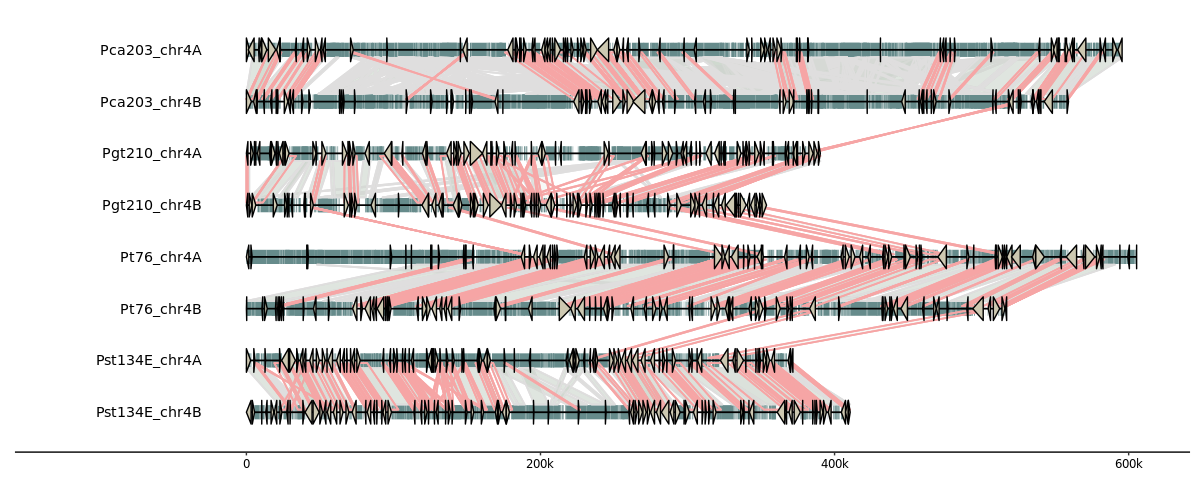

In [13]:
#Plot HD locus
options(repr.plot.width=10, repr.plot.height=4)
HD_40genes<-get_flanking(Annotation_gff, HD_list$gene_id, 40)
HD_40genes$seq_id<-factor(HD_40genes$seq_id, levels=
  c("Pca203_chr4A", "Pca203_chr4B", "Pgt210_chr4A", "Pgt210_chr4B", 
  "Pt76_chr4A", "Pt76_chr4B","Pst134E_chr4A", "Pst134E_chr4B"))
gggenomes(HD_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="#dfdede") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
gggenomes(HD_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="#dfdede") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 640 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


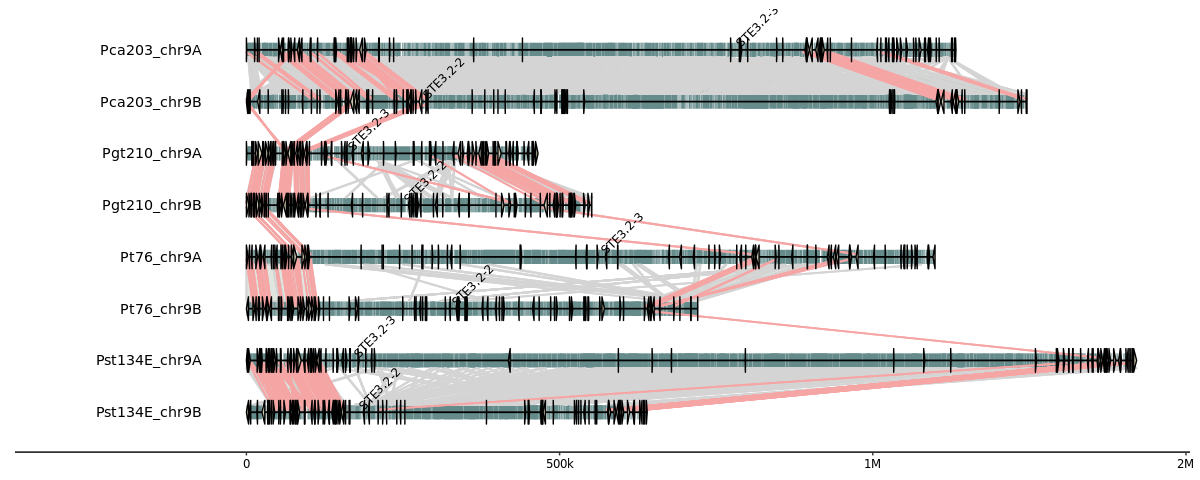

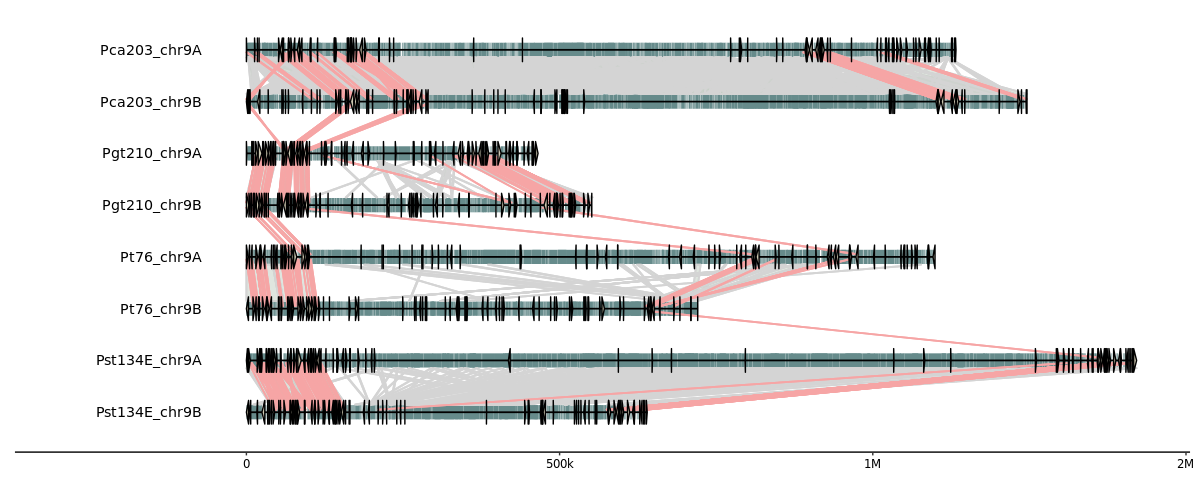

In [14]:
#Plot PR locus
options(repr.plot.width=10, repr.plot.height=4)
PR_list<-rbind(STE3.2_list, STE3.3_list)
PR_40genes<-get_flanking(Annotation_gff, PR_list$gene_id, 40)
PR_40genes$seq_id<-factor(PR_40genes$seq_id, levels=
  c("Pca203_chr9A", "Pca203_chr9B", "Pgt210_chr9A", "Pgt210_chr9B", 
  "Pt76_chr9A", "Pt76_chr9B","Pst134E_chr9A", "Pst134E_chr9B"))
gggenomes(PR_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()+geom_gene_tag(aes(label=MAT))
gggenomes(PR_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 640 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


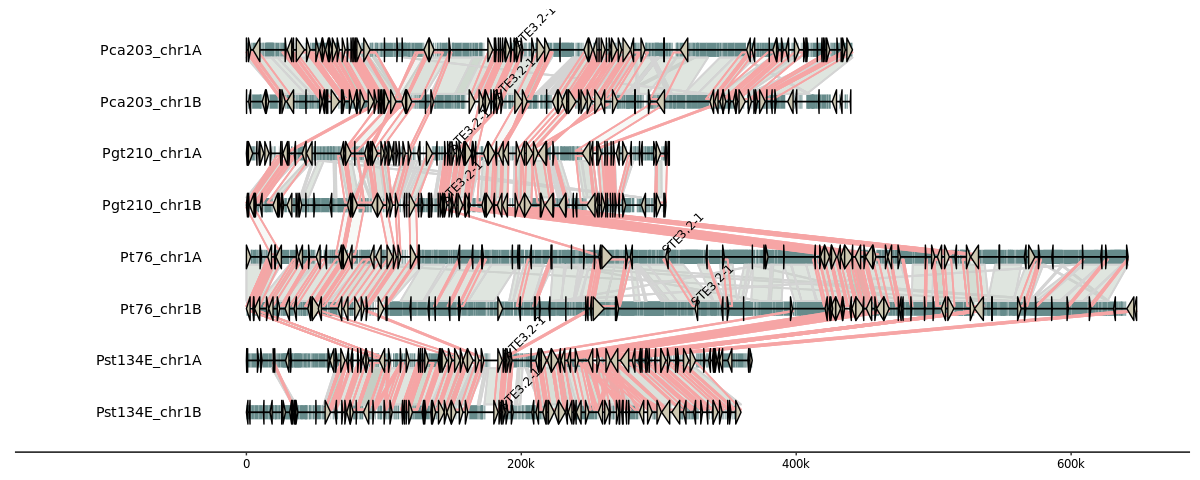

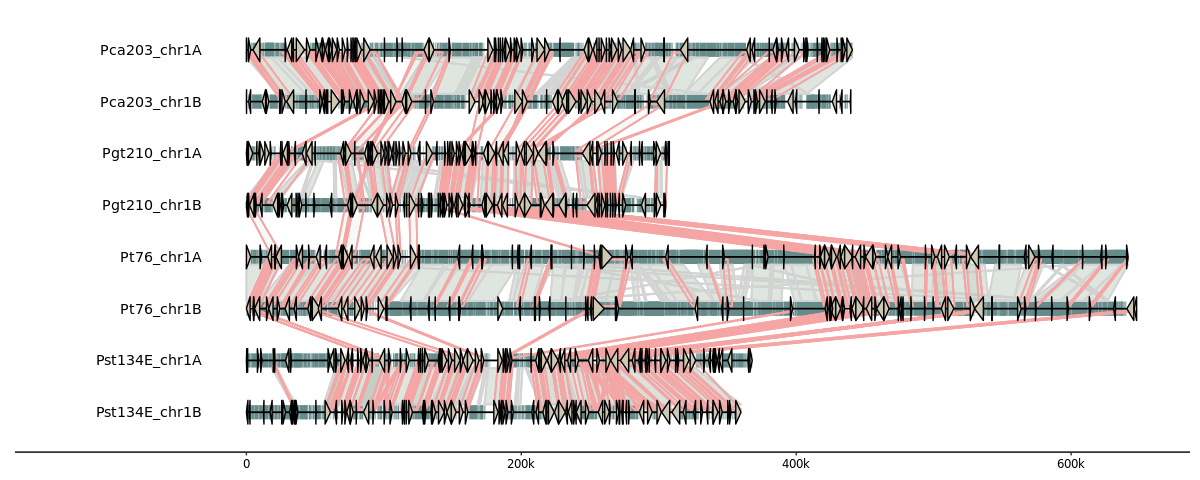

In [15]:
#Plot STE3.2-1 
options(repr.plot.width=10, repr.plot.height=4)
STE31_40genes<-get_flanking(Annotation_gff, STE3.1_list$gene_id, 40)
STE31_40genes$seq_id<-factor(STE31_40genes$seq_id, levels=
  c("Pca203_chr1A", "Pca203_chr1B", "Pgt210_chr1A", "Pgt210_chr1B", 
  "Pt76_chr1A", "Pt76_chr1B","Pst134E_chr1A", "Pst134E_chr1B"))
gggenomes(STE31_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
gggenomes(STE31_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 320 rows containing missing values (`geom_feat_text()`).”


seq_id,start,end
<fct>,<int>,<int>
Pca203_chr9A,1747045,2879872
Pca203_chr9B,1478299,2724497
Pgt210_chr9A,1254521,1720100
Pgt210_chr9B,1244195,1795601
Pst134E_chr9A,2805836,4227029
Pst134E_chr9B,2786619,3426502
Pt76_chr9A,1586317,2685664
Pt76_chr9B,1540370,2261000


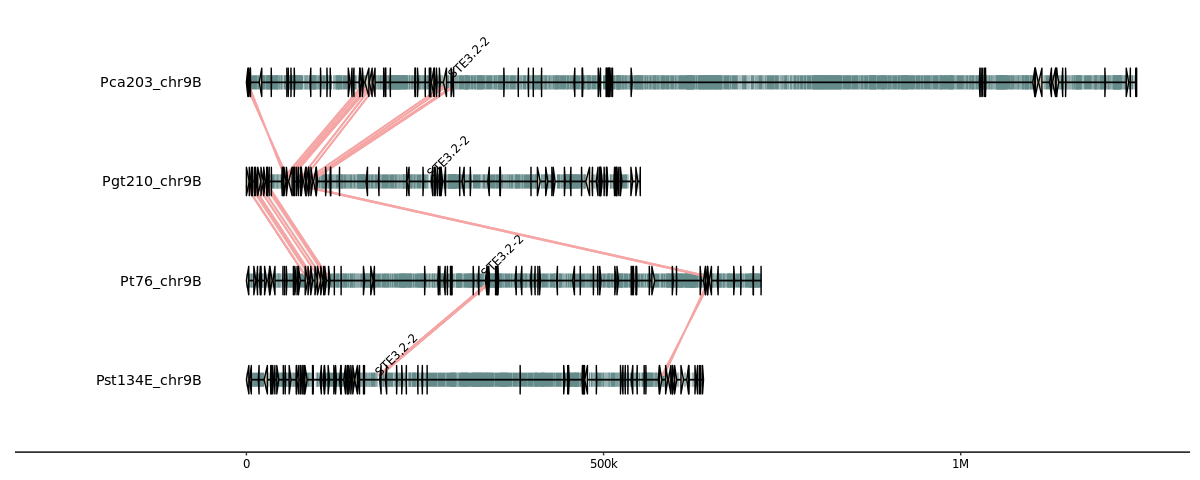

In [16]:
#Plot STE3.2-2 only
options(repr.plot.width=10, repr.plot.height=4)
STE32_40genes<-get_flanking(Annotation_gff, STE3.2_list$gene_id, 40)
STE32_40genes$seq_id<-factor(STE32_40genes$seq_id, levels=
  c("Pca203_chr9B", "Pgt210_chr9B", 
  "Pt76_chr9B", "Pst134E_chr9B"))
gggenomes(STE32_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=6)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
PR_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 320 rows containing missing values (`geom_feat_text()`).”


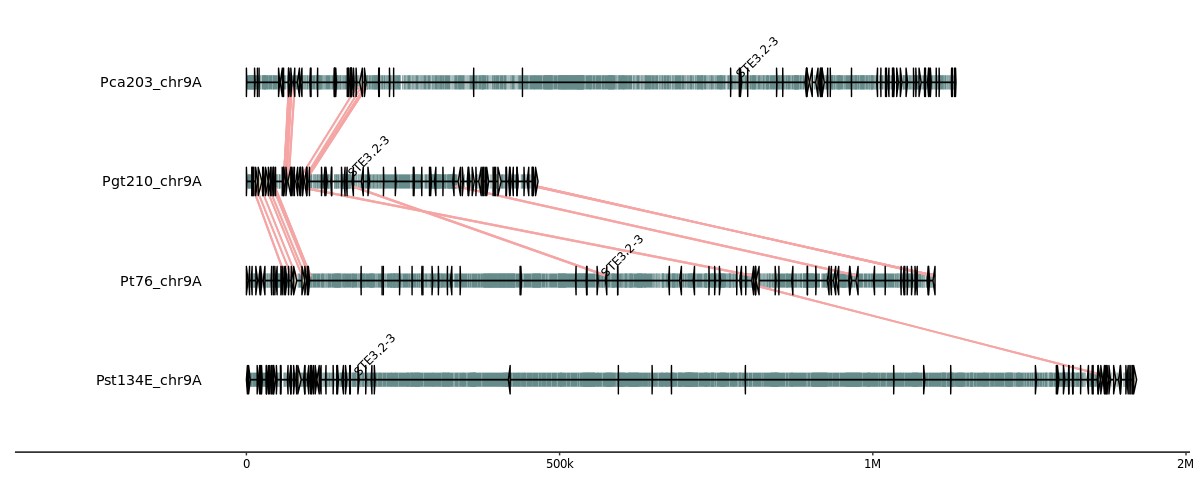

In [17]:
#Plot STE3.2-3 only
options(repr.plot.width=10, repr.plot.height=4)
STE33_40genes<-get_flanking(Annotation_gff, STE3.3_list$gene_id, 40)
STE33_40genes$seq_id<-factor(STE33_40genes$seq_id, levels=
  c("Pca203_chr9A", "Pgt210_chr9A", 
  "Pt76_chr9A", "Pst134E_chr9A"))
gggenomes(STE33_40genes)%>%add_links(links=coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=6)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))

In [18]:
get_RM_by_MAT<-function(RM, gff, gene, flank){
    region<-get_flanking(gff, gene, flank)
    region<-region%>%group_by(seq_id)%>%summarise(start=min(start), end=max(end))
    phase<-merge(RM, region, by="seq_id")%>%filter(start.x>=start.y & end.x<=end.y)%>%mutate(range=end.y-start.y)%>%select(-c(start.y, end.y))
    return(phase)
}

`summarise()` has grouped output by 'seq_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'seq_id'. You can override using the
`.groups` argument.


seq_id,parent_ids,coverage
<fct>,<chr>,<dbl>
Pca203_chr9A,Pca_12NC29_ph-B-R4761-Map4,7.846211
Pca203_chr9A,Pca_12NC29_ph-B-G12277-Map3,6.243142
Pca203_chr9A,Pca_12NC29_ph-B-R9893-Map5,6.000122
Pca203_chr9A,Pca_12NC29_ph-B-G1948-Map3,5.975405
Pca203_chr9A,Pca_12NC29_ph-B-G12338-Map3_reversed,5.152773
Pca203_chr9B,Pca_12NC29_ph-B-G12338-Map3_reversed,9.399229
Pca203_chr9B,Pca_12NC29_ph-B-G11747-Map3,6.943519
Pca203_chr9B,Pca_12NC29_ph-B-G3074-Map20,6.251013
Pca203_chr9B,Pca_12NC29_ph-B-P254.73-Map3_reversed,5.532909


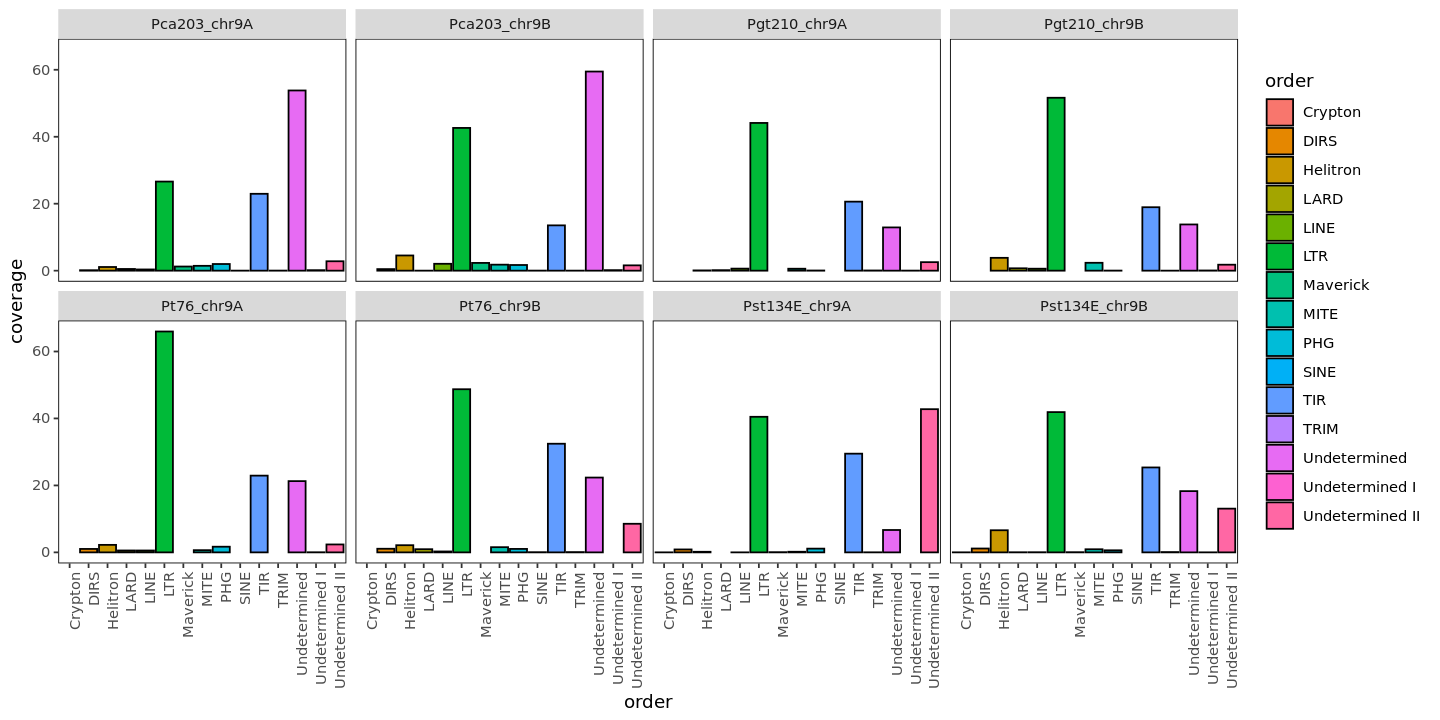

In [27]:
PR_locus_RM <- get_RM_by_MAT(RM_all, Annotation_gff, PR_list$gene_id, 40)
#Make plot and get TE family which have top (5) coverage
PR_locus_RM$seq_id<-factor(PR_locus_RM$seq_id, levels=
  c("Pca203_chr9A", "Pca203_chr9B", "Pgt210_chr9A", "Pgt210_chr9B", 
  "Pt76_chr9A", "Pt76_chr9B","Pst134E_chr9A", "Pst134E_chr9B"))
PR_locus_RM <- PR_locus_RM %>% mutate(length = end.x - start.x) %>% mutate(parent_ids = gsub("Motif:", "", parent_ids))
PR_locus_RM <- merge(PR_locus_RM, class_RM, by = "parent_ids", all = TRUE) %>% drop_na(seq_id) %>% arrange(seq_id, start.x, IDY) %>% mutate(parent_ids = as.character(parent_ids))
PR_locus_RM <- PR_locus_RM %>% mutate(order = ifelse(grepl("\\)n", parent_ids), "Tandem repeats", order))%>%drop_na(order)
PR_locus_RM <-PR_locus_RM%>%mutate(order=ifelse(order == "Unclassified", "Undetermined", order))
T_coverage <- PR_locus_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, order) %>% summarize(coverage = sum(coverage)) %>% arrange(seq_id, desc(coverage))

# Create the barplot
options(repr.plot.width=12, repr.plot.height=6)
PR_locus_TEcov<-ggplot(T_coverage, aes(x = order, y = coverage, fill = order)) +
    geom_bar(stat = "identity", color = "black") +
    facet_wrap(~seq_id, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_rect(fill = "white"),
    panel.border = element_rect(color = "black", fill = NA),legend.key=element_blank())
PR_locus_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, parent_ids) %>% summarize(coverage = sum(coverage))%>%top_n(5, coverage)%>%arrange(seq_id, desc(coverage))
PR_locus_TEcov
ggsave(paste0(folder,"4fungi_gggenome/PR_locus_TEcov.svg"), width=3000, height=1500, units="px", dpi=300)

`summarise()` has grouped output by 'seq_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'seq_id'. You can override using the
`.groups` argument.


seq_id,parent_ids,coverage
<fct>,<chr>,<dbl>
Pca203_chr1A,Pca_12NC29_ph-B-R11978-Map4,3.566293
Pca203_chr1A,Pca_12NC29_ph-B-G12163-Map3,2.651871
Pca203_chr1A,Pca_12NC29_ph-B-R11076-Map4_reversed,2.152476
Pca203_chr1A,Pca_12NC29_ph-B-G12145-Map11,1.913665
Pca203_chr1A,Pca_12NC29_ph-B-R15614-Map4,1.884636
Pca203_chr1B,Pca_12NC29_ph-B-R11978-Map4,2.834128
Pca203_chr1B,Pca_12NC29_ph-B-G12163-Map3,2.567362
Pca203_chr1B,Pca_12NC29_ph-B-R16257-Map3,2.085001
Pca203_chr1B,Pca_12NC29_ph-B-R15614-Map4,1.885325


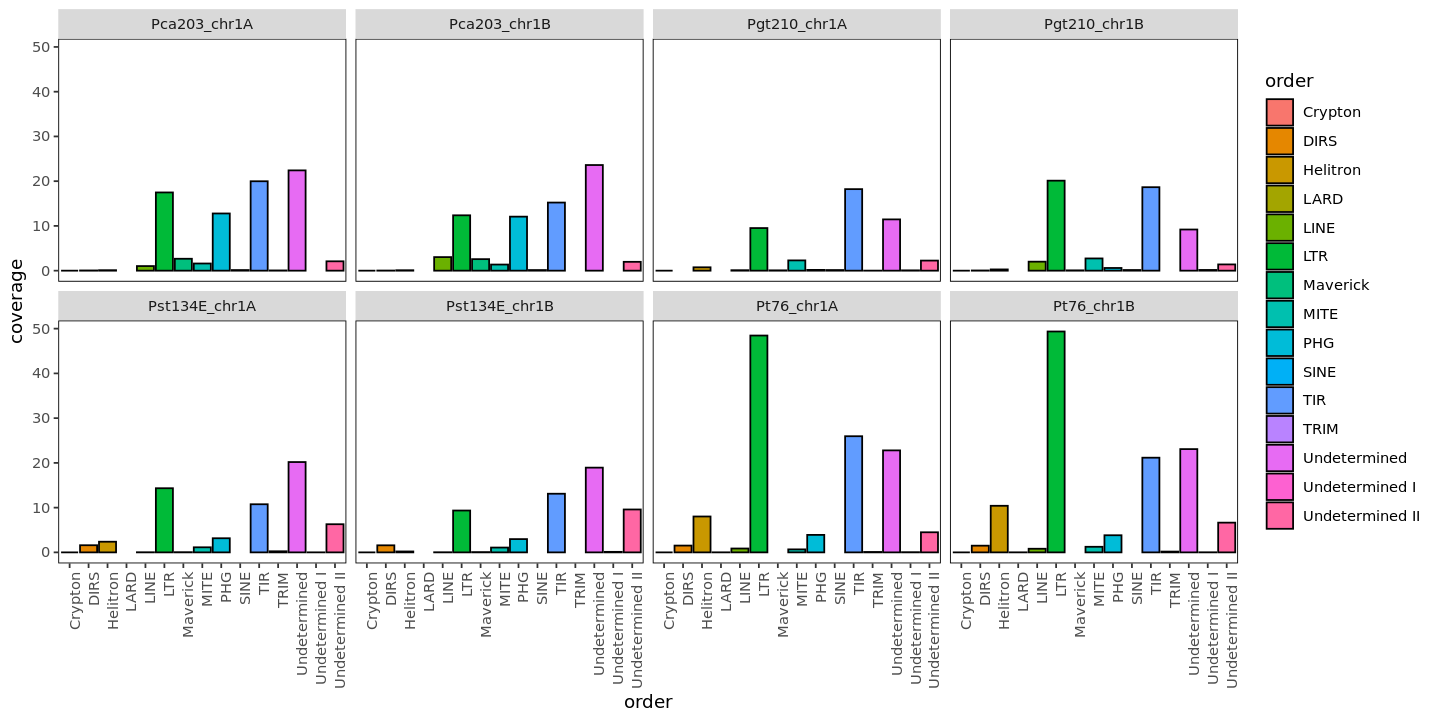

In [29]:
STE31_locus_RM <- get_RM_by_MAT(RM_all, Annotation_gff, STE3.1_list$gene_id, 40)
# Now sort by chr, then start, IDY
STE31_locus_RM$seq_id<-factor(STE31_locus_RM$seq_id, levels=
  c("Pca203_chr1A", "Pca203_chr1B", "Pgt210_chr1A", "Pgt210_chr1B", 
  "Pt76_chr1A", "Pt76_chr1B","Pst134E_chr1A", "Pst134E_chr1B"))
STE31_locus_RM <- STE31_locus_RM %>% mutate(length = end.x - start.x) %>% mutate(parent_ids = gsub("Motif:", "", parent_ids))
STE31_locus_RM <- merge(STE31_locus_RM, class_RM, by = "parent_ids", all = TRUE) %>% drop_na(seq_id) %>% arrange(seq_id, start.x, IDY) %>% mutate(parent_ids = as.character(parent_ids))
STE31_locus_RM <- STE31_locus_RM %>% mutate(order = ifelse(grepl("\\)n", parent_ids), "Tandem repeats", order))%>%drop_na(order)
STE31_locus_RM <-STE31_locus_RM%>%mutate(order=ifelse(order == "Unclassified", "Undetermined", order))
T_coverage <- STE31_locus_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, order) %>% summarize(coverage = sum(coverage)) %>% arrange(seq_id, desc(coverage))
#Make an empty value for "Crypton" to make legend consistent
T_coverage<-rbind(T_coverage, data.frame(seq_id=c("Pca203_chr1A", "Pca203_chr1B", "Pgt210_chr1A", "Pgt210_chr1B", 
  "Pt76_chr1A", "Pt76_chr1B","Pst134E_chr1A", "Pst134E_chr1B"), order="Crypton", coverage=0))
# Create the barplot
options(repr.plot.width=12, repr.plot.height=6)

STE31_locus_TEcov<-ggplot(T_coverage, aes(x = order, y = coverage, fill = order)) +
    geom_bar(stat = "identity", color = "black") +
    facet_wrap(~seq_id, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_rect(fill = "white"),
    panel.border = element_rect(color = "black", fill = NA),legend.key=element_blank())
    STE31_locus_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, parent_ids) %>% summarize(coverage = sum(coverage))%>%top_n(5, coverage)%>%arrange(seq_id, desc(coverage))
STE31_locus_TEcov
ggsave(paste0(folder,"4fungi_gggenome/STE31_locus_TEcov.svg"), width=3000, height=1500, units="px", dpi=300)

`summarise()` has grouped output by 'seq_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'seq_id'. You can override using the
`.groups` argument.


seq_id,parent_ids,coverage
<fct>,<chr>,<dbl>
Pca203_chr4A,Pca_12NC29_ph-B-P254.73-Map3_reversed,6.613975
Pca203_chr4A,Pca_12NC29_ph-B-G11638-Map4,3.177945
Pca203_chr4A,Pca_12NC29_ph-B-R13094-Map4,2.614089
Pca203_chr4A,Pca_12NC29_ph-B-G9663-Map16,2.491680
Pca203_chr4A,Pca_12NC29_ph-B-G3023-Map20,2.087342
Pca203_chr4B,Pca_12NC29_ph-B-P254.73-Map3_reversed,7.037190
Pca203_chr4B,Pca_12NC29_ph-B-G3023-Map20,4.378279
Pca203_chr4B,Pca_12NC29_ph-B-G12289-Map3,3.576992
Pca203_chr4B,Pca_12NC29_ph-B-G12007-Map3,2.924159


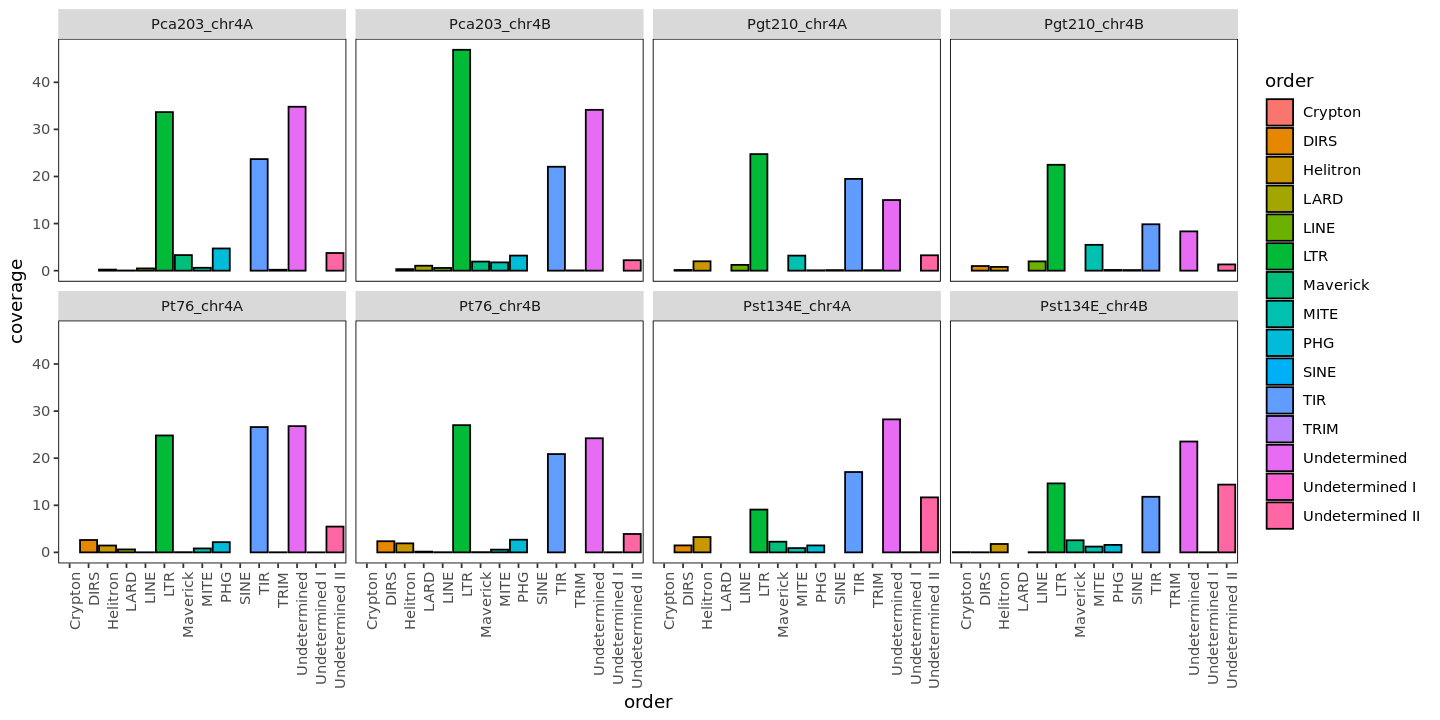

In [28]:
HD_locus_RM <- get_RM_by_MAT(RM_all, Annotation_gff, HD_list$gene_id, 40)
HD_locus_RM <- HD_locus_RM %>% mutate(length = end.x - start.x) %>% mutate(parent_ids = gsub("Motif:", "", parent_ids))
HD_locus_RM$seq_id<-factor(HD_locus_RM$seq_id, levels=
  c("Pca203_chr4A", "Pca203_chr4B", "Pgt210_chr4A", "Pgt210_chr4B", 
  "Pt76_chr4A", "Pt76_chr4B","Pst134E_chr4A", "Pst134E_chr4B"))
HD_locus_RM <- merge(HD_locus_RM, class_RM, by = "parent_ids", all = TRUE) %>% drop_na(seq_id) %>% arrange(seq_id, start.x, IDY) %>% mutate(parent_ids = as.character(parent_ids))
HD_locus_RM <-HD_locus_RM %>% mutate(order = ifelse(grepl("\\)n", parent_ids), "Tandem repeats", order))%>%drop_na(order)
HD_locus_RM <-HD_locus_RM%>%mutate(order=ifelse(order == "Unclassified", "Undetermined", order))
T_coverage <- HD_locus_RM%>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, order) %>% summarize(coverage = sum(coverage)) %>% arrange(seq_id, desc(coverage))

# Create the barplot
options(repr.plot.width=12, repr.plot.height=6)
HD_locus_TEcov<-ggplot(T_coverage, aes(x = order, y = coverage, fill = order)) +
    geom_bar(stat = "identity", color = "black") +
    facet_wrap(~seq_id, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_rect(fill = "white"),
    panel.border = element_rect(color = "black", fill = NA),legend.key=element_blank())
HD_locus_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, parent_ids) %>% summarize(coverage = sum(coverage))%>%top_n(5, coverage)%>%arrange(seq_id, desc(coverage))
HD_locus_TEcov
ggsave(paste0(folder,"4fungi_gggenome/HD_locus_TEcov.svg"), width=3000, height=1500, units="px", dpi=300)

In [22]:
find_topcov_TE<-function(RM_table, Annotation_gff, gene_list, flanking_size, top_value){
    get_RM <- get_RM_by_MAT(RM_all, Annotation_gff, gene_list$gene_id, flanking_size)
    test<-test%>%mutate(length=end.x -start.x)%>%mutate(parent_ids=gsub("Motif:", "", parent_ids))
    T_coverage<-test%>%mutate(coverage=(length/range)*100 )%>%group_by(seq_id,parent_ids)%>%summarize(coverage=sum(coverage))%>%arrange(seq_id, desc(coverage))
    #Print top 10 for each group, print all
    top_coverage<-T_coverage%>%group_by(seq_id)%>%top_n(top_value, coverage)
    #Find parent_ids which occur in all seq_id
#    top_coverage%>%group_by(parent_ids)%>%filter(n()>=minimum_occurance)#%>%ungroup()%>%select(parent_ids)%>%unique()
    return(top_coverage)
}